In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import utils
import utils_test
import joblib  
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patricialeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patricialeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/patricialeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Carga de datos

In [2]:
def load_data(train_path, test_path):
    
    train_data = pd.read_parquet(train_path)
    test_data = pd.read_parquet(test_path)
    return train_data, test_data


### Check de Distribución de Clases

In [3]:
def check_class_distribution(data, target_column):
    
    class_counts = data[target_column].value_counts()
    print("\nDistribución de clases:")
    print(class_counts)


### Preprocesamiento de texto (normalización)

In [4]:
def preprocess_text(data, text_column):
    
    data['normalized_text'] = utils.transform_text(data[text_column])
    print("\n Head de los textos normalizados:")
    print(data['normalized_text'].head())
    return data

### Crea características usando BoW
Regresa los datos transformados y el vectorizados

In [5]:
def create_features(train_data, test_data, text_column):

    vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.95)
    X_train = vectorizer.fit_transform(train_data[text_column])
    X_test = vectorizer.transform(test_data[text_column])
    return X_train, X_test, vectorizer

### Balanceo de Clases
Para el conjunto de entrenamiento

In [6]:
def balance_data(X_train, y_train):

    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("\nDistribución de clases después del balanceo:")
    print(pd.Series(y_train_balanced).value_counts())
    return X_train_balanced, y_train_balanced


### Entrenamiento del modelo

In [7]:
def train_naive_bayes(X_train, y_train):
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model


### Evaluación del modelo
Regresa como output las predicciones de proba y pertenencia a las 2 clases (positiva y negativa)

In [8]:
def evaluate_model(model, X_test, y_test):

    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Proba de ser positiva
    y_pred = (y_pred_proba >= 0.5).astype(int)  # Clasif binaria basada en umbral
    
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["Negativa", "Positiva"]))
    print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.4f}")
    return y_pred_proba, y_pred

### Pipeline

In [9]:
def main_pipeline(train_path, test_path):
   
    # Carga de datos
    train_data, test_data = load_data(train_path, test_path)
    
    # Check de distr de clases
    print("Distribución de clases inicial:")
    check_class_distribution(train_data, 'polarity')
    check_class_distribution(test_data, 'polarity')
    
    # Preprocesamiento de texto
    train_data = preprocess_text(train_data, 'text')
    test_data = preprocess_text(test_data, 'text')
    
    # Conversión de labels de {1, 2} a {0, 1}
    train_data['polarity'] = (train_data['polarity'] == 2).astype(int)
    test_data['polarity'] = (test_data['polarity'] == 2).astype(int)
    
    # Creación de características
    X_train, X_test, vectorizer = create_features(train_data, test_data, 'normalized_text')
    y_train = train_data['polarity']
    y_test = test_data['polarity']
    
    # Balanceo
    X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
    
    # Entrenamiento del modelo
    model = train_naive_bayes(X_train_balanced, y_train_balanced)


    
    # Guarda el modelo y el vectorizador
    joblib.dump(model, "naive_bayes_model.pkl")
    joblib.dump(vectorizer, "vectorizer.pkl")
    
    # Evaluación
    y_pred_proba, y_pred = evaluate_model(model, X_test, y_test)
    
    # Visualización de métricas
    utils_test.plot_roc_auc(y_pred_proba, y_test)
    utils_test.plot_precision_recall_curve(y_pred_proba, y_test)
    utils_test.plot_confusion_matrix_and_metrics(y_pred_proba, y_test)

### Ejecución de Pipeline

Distribución de clases inicial:

Distribución de clases:
polarity
2    150000
1    150000
Name: count, dtype: int64

Distribución de clases:
polarity
2    40000
1    40000
Name: count, dtype: int64


/Users/patricialeon/Documents/GitHub/up_nlp/utils.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  doc = BeautifulSoup(doc, "html.parser").get_text()



 Head de los textos normalizados:
0    being a metal head from the early early s i ha...
1    to anybody not familiar with van s non radio r...
2    for the past few months i have been doing medi...
3    this is a truly terrible book even though it i...
4    i love this pillow and can t imagine pregnancy...
Name: normalized_text, dtype: object


/Users/patricialeon/Documents/GitHub/up_nlp/utils.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  doc = BeautifulSoup(doc, "html.parser").get_text()



 Head de los textos normalizados:
0    was the year i realised that the new wave of b...
1    this was the second rain gauge i had purchased...
2    i was pleasantly surprised by the time taken w...
3    works finesound is good not wery loud but clar...
4    you might find the same product locally in som...
Name: normalized_text, dtype: object

Distribución de clases después del balanceo:
polarity
1    150000
0    150000
Name: count, dtype: int64

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativa       0.81      0.80      0.81     40000
    Positiva       0.81      0.81      0.81     40000

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

Precisión del modelo: 0.8065


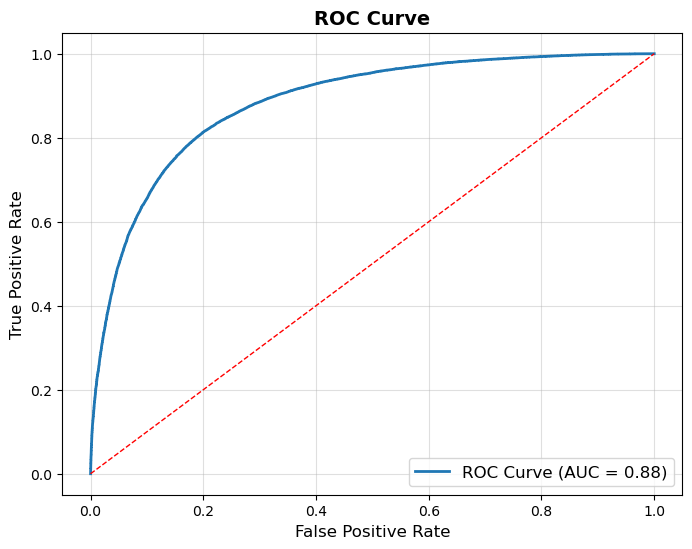

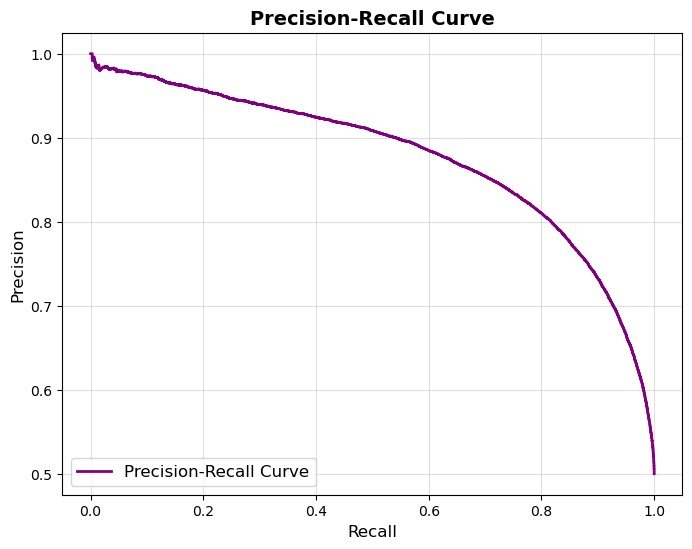

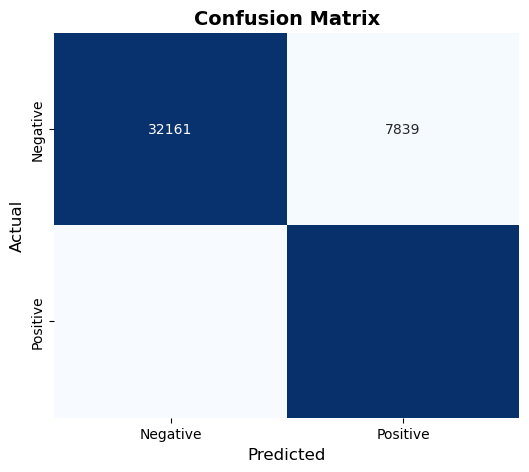

Classification Metrics:

              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81     40000
    Positive       0.81      0.81      0.81     40000

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

Accuracy: 0.81


In [10]:
if __name__ == "__main__":
    train_path = "data/data_train.parquet"
    test_path = "data/data_test.parquet"
    main_pipeline(train_path, test_path)



### Una prueba adicional con un comment fabricado

In [11]:
def preprocess_text(text):

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())
    return text


def predict_review(review):

    model = joblib.load("naive_bayes_model.pkl")
    vectorizer = joblib.load("vectorizer.pkl")
    

    processed_review = preprocess_text(review)
    review_features = vectorizer.transform([processed_review])
    

    prediction = model.predict(review_features)[0]
    prediction_proba = model.predict_proba(review_features)[0]
    
    print(f"Review: {review}")
    print(f"Predicción: {'Positiva' if prediction == 1 else 'Negativa'}")
    print(f"Probabilidad (Negativa, Positiva): {prediction_proba}")
    return prediction

if __name__ == "__main__":
    # Hay un caso negativo y uno positivo para probar
    sample_review = "The product was awful. Tha package was damaged and delivery service was not the best" #"An amazing product, exceeded my expectations! i will definitely but another one for my mom"
    predict_review(sample_review)


Review: The product was awful. Tha package was damaged and delivery service was not the best
Predicción: Negativa
Probabilidad (Negativa, Positiva): [0.93323684 0.06676316]
